### Load base model

In [ ]:
from ptlpinns.models import model, training, load
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

name = "undamped_nonlinear"
base_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}/"
base_name = f"model_{name}.pth"
base_model, training_log = model.load_model(base_path, base_name)

7 True True True 1.0 16 [256, 256, 512]


### Initialize transfer learning model

In [ ]:
transfer_model = model.transfer_model(training_log, base_model)

### Transfer learning parameters

In [6]:
w_transfer = [1]
zeta_transfer = [0]
q = 3
N = 512
t_span = (0, 15)
t_eval = np.linspace(t_span[0], t_span[1], N)
ic = [1, 0]
initial_condition_functions = [load.initial_condition(y1_0=ic[0], y2_0=ic[1])]
epsilon = 0.5
equation_functions = [equations.equation_oscillator(w_0=w_transfer[0], epsilon=epsilon)]
forcing_functions = [forcing.zeroes_2D(False)]

In [7]:
ode = equations.ode_oscillator_1D(w_0=w_transfer[0], zeta=zeta_transfer[0], forcing_1D = lambda t: np.zeros_like(t), q=q, epsilon=epsilon)
numerical_solution = numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic)

### Training

In [8]:
def evaluate_MAE(transfer_model, numerical_solution):

    t_eval_torch = training.generate_eval_tensor(N, t_span, False)
    model_result = transfer_model(t_eval_torch)[0].squeeze()[:, 0].detach().numpy()
    return np.mean(np.abs(model_result - numerical_solution[0, :]))

In [10]:
def compute_transfer_learning(model, optimizer, num_iter, equation_functions, ic, forcing_functions, numerical_solution=numerical_solution, 
                            N=512, t_span=(0, 1), every=100, ode_weight=1, ic_weight=1, method='equally-spaced-noisy', scheduler=None):

       total_time = 0.0

       for it in range(1, num_iter):

              start_time = time.perf_counter()
              optimizer.zero_grad()
              total, ode, ic, _ = training.loss(
              model=model, N=N, t_span=t_span,
              equation_functions=equation_functions,
              initial_condition_functions=initial_condition_functions,
              forcing_functions=forcing_functions,
              ode_weight=ode_weight, ic_weight=ic_weight, method=method)
              total.backward()
              optimizer.step()

              if scheduler is not None:
                     scheduler.step()

              end_time = time.perf_counter()
              total_time += end_time - start_time

              MAE = evaluate_MAE(transfer_model, numerical_solution)

              if MAE < 1e-2:
                     print(f"Converged at iteration {it}: MAE = {MAE} | time {total_time}")
                     break

              if it % every == 0:
                     print(f"[iteration] {it} | total {total.item():.3e} | ode {ode.item():.3e} | ic {ic.item():.3e} | MAE {MAE:.3e} | time {total_time:.2f}")

In [ ]:
optimizer = torch.optim.Adam(model.head_parameters(transfer_model), lr=1e-2)
num_iter = 20000
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.95)

In [12]:
compute_transfer_learning(transfer_model, optimizer, num_iter,
                        equation_functions, ic, forcing_functions,
                        N=N, t_span=t_span, numerical_solution=numerical_solution, every=200)

[iteration] 200 | total 6.062e-04 | ode 5.946e-04 | ic 1.157e-05 | MAE 2.204e-01 | time 8.49
[iteration] 400 | total 3.852e-04 | ode 3.775e-04 | ic 7.738e-06 | MAE 2.004e-01 | time 18.65
[iteration] 600 | total 2.987e-04 | ode 2.932e-04 | ic 5.481e-06 | MAE 1.843e-01 | time 28.36
[iteration] 800 | total 2.486e-04 | ode 2.443e-04 | ic 4.290e-06 | MAE 1.697e-01 | time 37.58
[iteration] 1000 | total 2.166e-04 | ode 2.134e-04 | ic 3.203e-06 | MAE 1.564e-01 | time 47.10
[iteration] 1200 | total 1.891e-04 | ode 1.864e-04 | ic 2.761e-06 | MAE 1.443e-01 | time 56.92
[iteration] 1400 | total 1.674e-04 | ode 1.653e-04 | ic 2.099e-06 | MAE 1.330e-01 | time 66.96
[iteration] 1600 | total 1.476e-04 | ode 1.459e-04 | ic 1.727e-06 | MAE 1.225e-01 | time 78.39
[iteration] 1800 | total 1.298e-04 | ode 1.286e-04 | ic 1.144e-06 | MAE 1.122e-01 | time 88.84
[iteration] 2000 | total 1.128e-04 | ode 1.116e-04 | ic 1.212e-06 | MAE 1.024e-01 | time 99.43
[iteration] 2200 | total 9.979e-05 | ode 9.906e-05 | ic

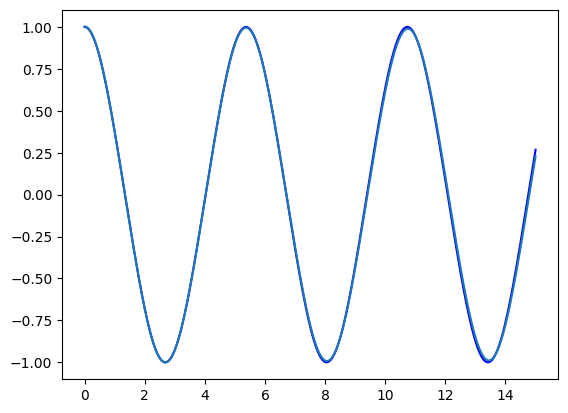

In [ ]:
plt.plot(t_eval, numerical_solution[0, :], label='Numerical Solution', color='blue')
plt.plot(t_eval, transfer_model(training.generate_eval_tensor(N, t_span, False))[0].squeeze()[:, 0].detach().numpy())